Adding a new problem
--------------------------

While many problems are already implemented from a wide range of options: (non-)linear, ODEs, PDEs, ND, hyperbolic, parabolic, ..., you may wish to add your own.
In particular if you have a problem from a specific domain, let us know and we help you bring this to the main repository!

Anyways, we will just do the typical hello-world example of the heat equation: $$u_t = \nu \Delta u.$$
This is a PDE, which makes it not the easiest problem to implement, but you will notice we have some utilities available to very quickly implement PDEs with finite differences in `N` dimensions.

Let's go through all the things we will need and start with the definition of the problem class.
We will inherit from a core problem class and already add the datatype for the solution and the right hand side as class attributes.
Class attributes are shared across all instances of the class, but you access them as usual with ``self.dtype_u``, for instance.
We choose ``mesh`` here, which is a wrapper for ``numpy.ndarray`` with some additional attributes that we need for pySDC, like a communicator.

In [1]:
import jdc  # required to split the class definition into multiple cells...

import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve

from pySDC.core.Problem import ptype
from pySDC.implementations.datatype_classes.mesh import mesh

class HeatEquation(ptype):
    """
    This is a very basic implementation of a heat equation with finite differences and periodic boundaries.
    """

    # set datatype of solution and right hand side evaluations as class attributes
    dtype_u = mesh
    dtype_f = mesh

Next, we write the `__init__` function which is called during object instantiation.
This takes as arguments all the attributes that the problem should have.

In [2]:
%%add_to HeatEquation

def __init__(self, nvars=128, ndim=1, stencil_type='center', space_order=2, nu=1.0, freq=2):
    """
    Initialization routine.
    
    Args:
        nvars (int): Number of degrees of freedom in each dimension
        ndim (int): Number of dimensions (1 or 2)
        stencil_type (string): Type of finite difference stencil
        space_order (int): Order of accuracy of the finite difference discrization
        nu (float): Coefficient in front of the Laplacian
        freq (int): Frequency of the initial conditions
    """
    from pySDC.helpers.problem_helper import get_finite_difference_matrix
    
    # create a tuple that can be used for pySDC datatype instantiation.
    # the format is (<shape>, <MPI communicator>, <datatype>)
    init = (nvars if ndim == 1 else [nvars for i in range(ndim)], None, np.dtype('float64'))

    # call the super init from the core problem module
    super(HeatEquation, self).__init__(init=init)

    # setup 1D spatial grid
    dx = 1.0 / nvars
    xvalues = np.array([i * dx for i in range(nvars)])

    # build the finite difference matrix
    self.A = get_finite_difference_matrix(
        derivative=2,
        order=space_order,
        stencil_type=stencil_type,
        dx=dx,
        size=nvars,
        dim=ndim,
        bc='periodic',
    )
    self.A *= nu

    # make the attributes accessible outside this function
    self.xvalues = xvalues
    self.dx = dx
    self.Id = sp.eye(np.power(nvars, ndim), format='csc')
    self._makeAttributeAndRegister(
        'nvars', 'stencil_type', 'space_order', 'ndim', 'nu', 'freq', localVars=locals(), readOnly=True
    )

Please note a few features in the above code.
The function for generating finite difference matrices is pretty general because it will generate a stencil by cancelling terms in Taylor expansions based on the input, so you can generate a wide range of stencils.
Options are order of derivative, order of accuracy, one-sided or centered stencils and the dimension by use of Kronecker products.

At the end of the ``__init__`` function, you will find the function ``_makeAttributeAndRegister``. This function will make the values available as ``params``.
So you can access them either as ``HeatEquation.nvars`` or ``HeatEquation.params.nvars`` for instance, but you are not allowed to change the parameters after the object instantiation is finished.

What else do we need?
It's really only two things: We need to evaluate the right hand side and we need to be able to perform implicit Euler steps. We define both in the following two functions:

In [3]:
%%add_to HeatEquation

def eval_f(self, u, t):
    """
    Routine to evaluate the RHS

    Parameters
    ----------
    u : dtype_u
        Current values.
    t : float
        Current time.

    Returns
    -------
    f : dtype_f
        The RHS values.
    """
    f = self.f_init
    f[:] = self.A.dot(u.flatten()).reshape(self.init[0])
    return f

def solve_system(self, rhs, factor, u0, t):
    """
    Simple linear solver for (I-factor*A)u = rhs.

    Parameters
    ----------
    rhs : dtype_f
        Right-hand side for the linear system.
    factor : float
        Abbrev. for the local stepsize (or any other factor required).
    u0 : dtype_u
        Initial guess for the iterative solver.
    t : float
        Current time (e.g. for time-dependent BCs).

    Returns
    -------
    sol : dtype_u
        The solution of the linear solver.
    """
    sol = self.u_init
    sol[:] = spsolve(self.Id - factor * self.A, rhs.flatten()).reshape(self.init[0])
    return sol

We are just solving the linear system that arises from the FD discretization directly here, but you can use iterative solvers for large problems or whatever you want.

It's also convenient to have a function that evaluates the exact solution.
If you don't have an exact solution available, you can still put in the initial conditions, which are the exact solution at $t=0$.
But for this simple problem, we have an exact solution available from $t\geq0$ with the following function:

In [4]:
%%add_to HeatEquation

def u_exact(self, t, **kwargs):
        """
        Routine to compute the exact solution at time t. Notably, this can be used for initial conditions at t=0.

        Args:
            t (float): current time

        Returns:
            dtype_u: exact solution
        """
        ndim, freq, nu, dx, sol = self.ndim, self.freq, self.nu, self.dx, self.u_init

        if ndim == 1:
            x = self.xvalues
            rho = (2.0 - 2.0 * np.cos(np.pi * freq * dx)) / dx**2
            if freq > 0:
                sol[:] = np.sin(np.pi * freq * x) * np.exp(-t * nu * rho)
        elif ndim == 2:
            rho = (2.0 - 2.0 * np.cos(np.pi * freq * dx)) / dx**2 + (2.0 - 2.0 * np.cos(np.pi * freq * dx)) / dx**2
            x, y = self.xvalues[None, :], self.xvalues[:, None]
            sol[:] = np.sin(np.pi * freq * x) * np.sin(np.pi * freq * y) * np.exp(-t * nu * rho)

        return sol

That's it!
All we need to add a problem class is a function to evaluate the right hand side, solve implicit Euler steps and some initial conditions.

Let's run this problem now just like we did in the last tutorial.
We will define a function that let's us enter problem parameters and returns the solution after every time step, the initial conditions and the spatial grid:

In [5]:
def run_heat(problem_params):
    from pySDC.implementations.sweeper_classes.generic_implicit import generic_implicit
    from pySDC.implementations.controller_classes.controller_nonMPI import controller_nonMPI
    
    from pySDC.helpers.stats_helper import get_sorted
    from pySDC.implementations.hooks.log_solution import LogSolution
    
    level_params = {}
    level_params['dt'] = 0.1
    level_params['restol'] = -1
    
    step_params = {}
    step_params['maxiter'] = 5
    
    sweeper_params = {}
    sweeper_params['QI'] = 'LU'
    sweeper_params['num_nodes'] = 3
    sweeper_params['quad_type'] = 'RADAU-RIGHT'
    sweeper_params['initial_guess'] = 'spread'
    
    controller_params = {}
    controller_params['logger_level'] = 30
    controller_params['hook_class'] = LogSolution
    
    description = {}
    description['level_params'] = level_params
    description['step_params'] = step_params
    description['sweeper_params'] = sweeper_params
    description['sweeper_class'] = generic_implicit
    description['problem_params'] = problem_params
    description['problem_class'] = HeatEquation
    
    controller = controller_nonMPI(num_procs=1, controller_params=controller_params, description=description)
    
    prob = controller.MS[0].levels[0].prob
    u_init = prob.u_exact(t=0)
    
    u_end, stats = controller.run(u0=u_init, t0=0, Tend=0.3)
    return get_sorted(stats, type='u'), u_init, prob.xvalues

Now let's run a 1D example:

Text(0.5, 0, '$x$')

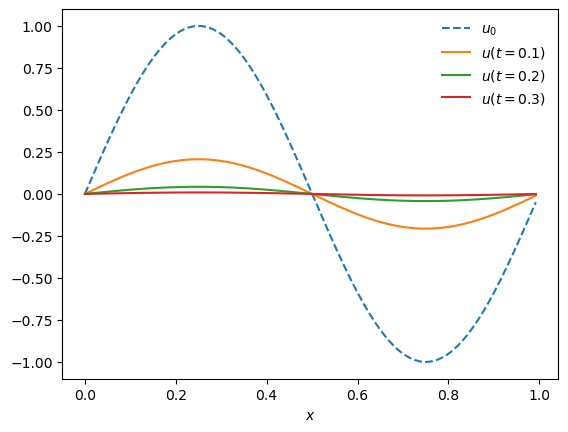

In [6]:
import matplotlib.pyplot as plt

problem_params = {}
problem_params['nvars'] = 128
problem_params['ndim'] = 1
problem_params['stencil_type'] = 'center'
problem_params['space_order'] = 4
problem_params['nu'] = 4e-1
problem_params['freq'] = 2

u, u_init, x = run_heat(problem_params)

ax = plt.subplot()

ax.plot(x, u_init, label=r'$u_0$', ls='--')

for me in u:
    ax.plot(x, me[1], label=rf'$u(t={{{me[0]:.1f}}})$')
    
ax.legend(frameon=False)
ax.set_xlabel(r'$x$')

We can easily do 2D as well.
But we have to drop the resolution per dimension because the total resolution scales with $N^2$, of course.
Also, we decrease the coefficient in front of the Laplacian because it makes it easier to see the evolution.

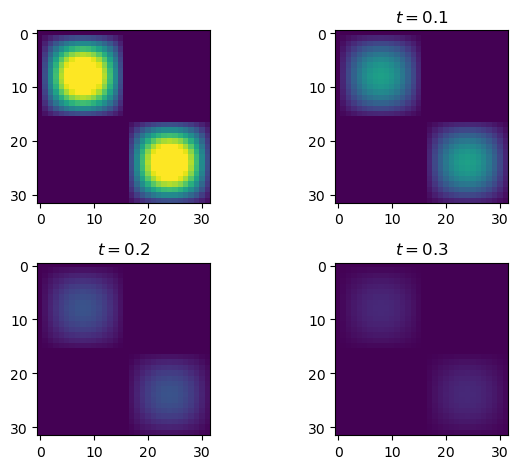

In [7]:
problem_params['nvars'] = 32
problem_params['ndim'] = 2
problem_params['nu'] = 1e-1

u, u_init, x = run_heat(problem_params)

fig, axs = plt.subplots(2, 2)

axs[0,0].imshow(u_init, vmin=0., vmax=0.8)

for i in range(3):
    axs.flatten()[i+1].set_title(fr'$t={{{u[i][0]:.1f}}}$')
    axs.flatten()[i+1].imshow(u[i][1], vmin=0., vmax=0.8)

fig.tight_layout()

I hope you agree that adding problems to pySDC is easy once you have a discrete version available.
In particular, FD discretizations are very simple to do in pySDC (at least with periodic boundaries).
Finite elements are also (partially) supported with FEniCS.

Now you know how to add a new problem to pySDC, run it, and record the data you deem interesting.
Congratulations on being a very proficient user of pySDC!

Now, we will look into the developer side of pySDC and write a custom sweeper that will speed up the problem we where looking at in the first notebook.
If you haven't started an ``ipcluster`` yet, please do so now!
Make sure you do this in a shell with the ``pySDC_tutorial`` virtual environment.